In [0]:
!pip install -q imageio

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import glob
import imageio
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = "/content/drive/My Drive/Tesis maestria/Gans Faces/"
dbfile = open(path + 'FaceData_images.pkl', 'rb')      
data = pickle.load(dbfile) 
dbfile.close() 

In [0]:
print('Shape: ', data['Images'].shape)
print('Max: ',data['Images'].max())
print('Min: ',data['Images'].min())

Shape:  (50022, 64, 64, 3)
Max:  1.0
Min:  0.0


In [0]:
X = (data['Images'] - 0.5) /0.5
print('Max value: ' + str(X.max()))
print('Min value: ' + str(X.min()))
X.shape

Max value: 1.0
Min value: -1.0


(50022, 64, 64, 3)

In [0]:
EPOCHS = 500
latent_dim = 100
num_examples_to_generate = 25
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, latent_dim])

In [0]:
img_rows = 64
img_cols = 64
channels = 3
img_shape = (img_rows, img_cols, channels) # Input image dimensions

In [0]:
BUFFER_SIZE = 50022
BATCH_SIZE = 128

In [0]:
# Load elements of size=buffer size and shuffle them at each iteration in n number of batches
train_dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset 

<BatchDataset shapes: (None, 64, 64, 3), types: tf.float32>

In [0]:
def build_generator(z_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, input_dim=z_dim))
    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5,5), strides=(2, 2), padding='same',activation='relu'))
    model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU(alpha=0.2))
    assert model.output_shape == (None, 8, 8, 512)

    model.add(layers.Conv2DTranspose(256, (5,5), strides=(2, 2), padding='same',activation='relu'))
    model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU(alpha=0.2))
    assert model.output_shape == (None, 16, 16, 256)

    model.add(layers.Conv2DTranspose(128, (5,5), strides=(2, 2), padding='same',activation='relu'))
    model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU(alpha=0.2))
    assert model.output_shape == (None, 32, 32, 128)

    model.add(layers.Conv2DTranspose(3, (5,5), strides=(2, 2), padding='same', activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

In [0]:
def build_discriminator(img_shape):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=img_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    #model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))
    #model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    #model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1))

    return model

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output, smoothing_factor = 0.9):
    # Compares the discriminator's predictions on real images to an array of 1s
    # Compares the discriminator's predictions on fake (generated) images to an array of 0s
    real_loss = cross_entropy(tf.ones_like(real_output)* smoothing_factor, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    # Labels are true here because generator thinks he produces real images. 
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
# The generator and discriminator optimizers are different since we will train two networks separately
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim]) # noise generated from normal distribution 

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) # generator produces an image 

      real_output = discriminator(images, training=True) # discriminator classify real images
      fake_output = discriminator(generated_images, training=True) # discriminator classify fake images

      # Calculate losses for each of the models
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output, smoothing_factor=0.9)

    # Adjusting Gradient of Discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    # Adjusting Gradient of Generator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return (disc_loss, gen_loss)

In [0]:
losses = []
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            d_loss, g_loss = train_step(image_batch)
            losses.append((d_loss.numpy(), g_loss.numpy()))
        # Produce images for the GIF as we go


        # Save the model every 15 epochs
        if (epoch + 1) % 10 == 0:
            display.clear_output(wait=True)
            generate_and_save_images(generator,epoch + 1,seed)
            #checkpoint.save(file_prefix = checkpoint_prefix)
            summarize_performance(epoch+1, generator)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print("%d [D loss: %4f] [G loss: %4f]" % (epoch + 1, d_loss.numpy(), g_loss.numpy()))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)

In [0]:
def summarize_performance(iteration, generator):
    filename = 'Generator_model_v1_%03d.h5' % (iteration)
    generator.save('/content/drive/My Drive/Tesis maestria/Gans Faces/' + filename)

In [0]:
def convert_array_to_image(array):
    """Converts a numpy array to a PIL Image and undoes any rescaling."""
    img = PIL.Image.fromarray(np.uint8((array + 1.0) / 2.0 * 255), mode='RGB')
    return img

In [0]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    #predictions = (predictions + 1) / 2.0
    fig = plt.figure(figsize=(6,6))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        predi = convert_array_to_image(predictions[i])
        plt.imshow(predi)
        plt.axis('off')

    plt.savefig('/content/drive/My Drive/Tesis maestria/Gans Faces/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [0]:
generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape)

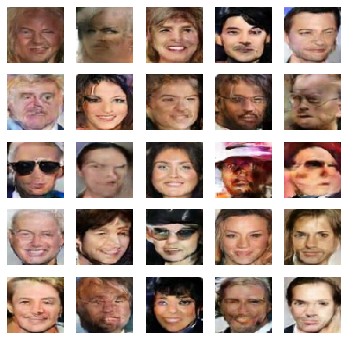

In [0]:
train(train_dataset, EPOCHS)

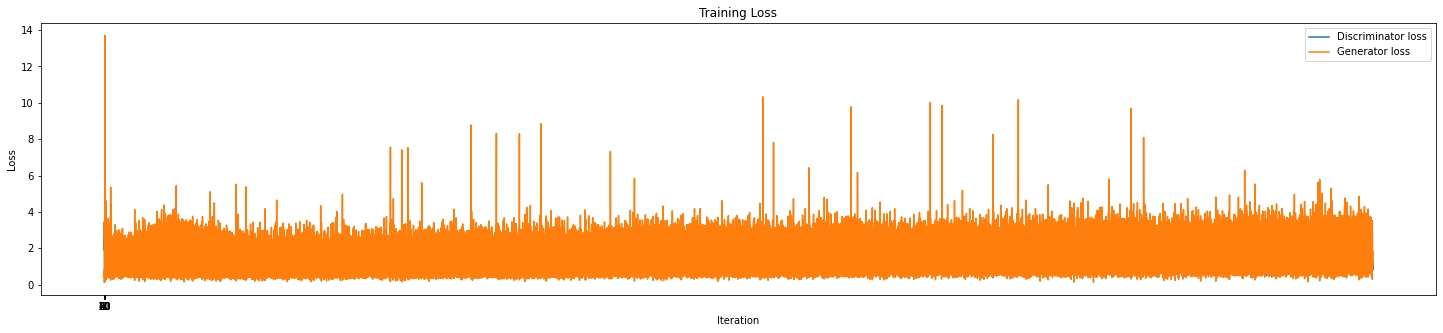

In [0]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(25, 5))
plt.plot(losses.T[0], label="Discriminator loss")
plt.plot(losses.T[1], label="Generator loss")
x = list(range(0, 61,10))
plt.xticks(x)
plt.title("Training Loss") 
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [0]:
idx = np.argsort(losses.T[1])[:10])
idx 

SyntaxError: ignored

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('/content/drive/My Drive/Tesis maestria/Gans Faces/image_at_epoch_{:04d}.png'.format(epoch_no))

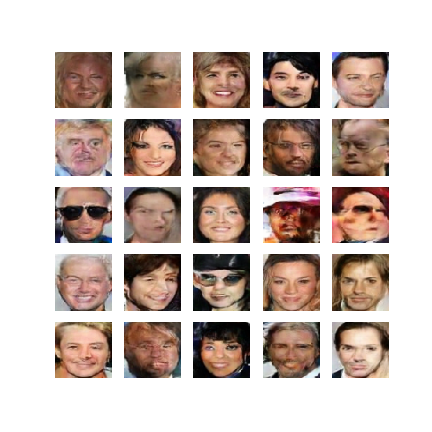

In [0]:
display_image(EPOCHS)

In [0]:
anim_file = '/content/drive/My Drive/Tesis maestria/Gans Faces/dcgan_faces.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/drive/My Drive/Tesis maestria/Gans Faces/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)